In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam, SGD, RMSprop
from torchvision.transforms import transforms as T
import torchvision
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import ConcatDataset, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
data_dir = "./data/Face Mask/"
print(os.listdir(data_dir))

['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant', 'without_mask', 'with_mask']


In [5]:
for i in os.listdir(data_dir):
    print(f"Class name {i} and No of Images {len(os.listdir(data_dir+i))}")

Class name diseased cotton leaf and No of Images 288
Class name diseased cotton plant and No of Images 815
Class name fresh cotton leaf and No of Images 427
Class name fresh cotton plant and No of Images 421
Class name without_mask and No of Images 3828
Class name with_mask and No of Images 3725


Text(0.5, 1.0, 'with_mask')

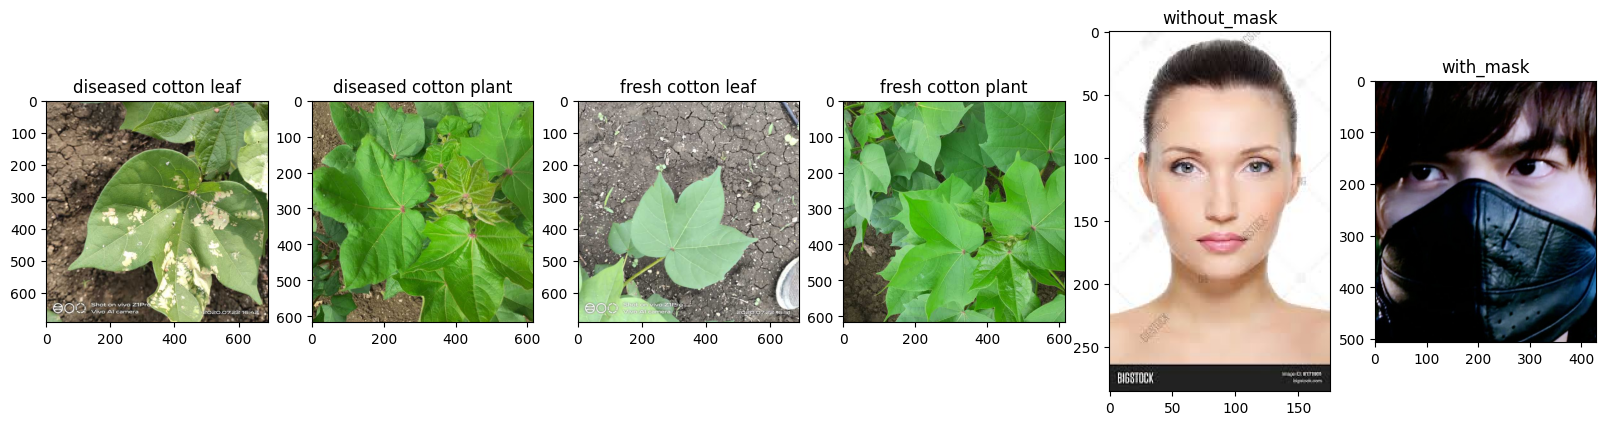

In [7]:
index = 100
im1 = mpimg.imread(data_dir+'diseased cotton leaf/'+(os.listdir(data_dir+'diseased cotton leaf'))[index])
im2 = mpimg.imread(data_dir+'diseased cotton plant/'+(os.listdir(data_dir+'diseased cotton plant'))[index])
im3 = mpimg.imread(data_dir+'fresh cotton leaf/'+(os.listdir(data_dir+'fresh cotton leaf'))[index])
im4 = mpimg.imread(data_dir+'fresh cotton plant/'+(os.listdir(data_dir+'fresh cotton plant'))[index])
im5 = mpimg.imread(data_dir+'without_mask/'+(os.listdir(data_dir+'without_mask'))[index])
im6 = mpimg.imread(data_dir+'with_mask/'+(os.listdir(data_dir+'with_mask'))[index])
plt.figure(figsize=(20,5))
plt.subplot(1,6,1)
plt.imshow(im1)
plt.title('diseased cotton leaf')
plt.subplot(1,6,2)
plt.imshow(im2)
plt.title('diseased cotton plant')
plt.subplot(1,6,3)
plt.imshow(im3)
plt.title('fresh cotton leaf')
plt.subplot(1,6,4)
plt.imshow(im4)
plt.title('fresh cotton plant')
plt.subplot(1,6,5)
plt.imshow(im5)
plt.title('without_mask')
plt.subplot(1,6,6)
plt.imshow(im6)
plt.title('with_mask')

In [9]:
image_size = 128
batch_size = 64
#stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [11]:
transform = T.Compose([
    T.Resize((image_size,image_size)),
    T.ToTensor(),
    #T.Normalize(*stats)
])

In [13]:
dataset = ImageFolder(data_dir,transform=transform)

In [15]:
dataset

Dataset ImageFolder
    Number of datapoints: 9504
    Root location: ./data/Face Mask/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [17]:
train_ds,test_ds = random_split(dataset,[9000,504])

In [19]:
im , lb = train_ds[0]
im.size()

torch.Size([3, 128, 128])

In [21]:
len(train_ds)

9000

In [23]:
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
test_dl = DataLoader(test_ds,batch_size=batch_size,shuffle=False)

In [25]:
len(train_dl)

141

In [115]:
data_dl = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [25]:
def denorm(images):
    return images * stats[1][0] + stats[0][0]

In [27]:
class FaceMaskDetectionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.NeuralNetwork = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1), # batch_size * 32 * 128 * 128
            nn.ReLU(),
            nn.MaxPool2d(2,2), # batch_size * 32 * 64 * 64

            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1), # batch_size * 64 * 32 * 32
            nn.ReLU(),
            nn.MaxPool2d(2,2), 

            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1), # batch_size * 64 * 16 * 16
            nn.ReLU(),
            nn.MaxPool2d(2,2), 

            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1), # batch_size * 128 * 8 * 8
            nn.ReLU(),
            nn.MaxPool2d(2,2), 

            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2,2), # batch_size * 128 * 4 * 4
            

            nn.Flatten(),
            nn.Linear(128*4*4,256), # batch_size * 256
            nn.Linear(256,6) # batch_size * 1
        )

    def forward(self,x):
        return self.NeuralNetwork(x)

In [39]:
x = torch.randn(64,3,128,128)
model = FaceMaskDetectionCNN()
model(x).size()

torch.Size([64, 6])

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [31]:
model = FaceMaskDetectionCNN()
model.to(device)

FaceMaskDetectionCNN(
  (NeuralNetwork): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_fe

In [45]:
for img , lbs in train_dl:
    print(img.size())
    break

torch.Size([64, 3, 128, 128])


In [33]:
criterion = F.cross_entropy #F.binary_cross_entropy_with_logits
optimizer = Adam(model.parameters(),lr=0.001)

In [35]:
epochs = 10

In [81]:
for img,lbs in train_dl:
    img,lbs = img.to(device), lbs.to(device,)
    output = model(img)
    # _,output = torch.max(output,1)
    # loss = criterion(output.to(dtype=torch.float),lbs.to(dtype=torch.float))
    print(lbs.view(-1,1).float().dtype)
    print(output.round()[:5])
    break

torch.float32
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<SliceBackward0>)


In [37]:
torch.cuda.empty_cache()

In [39]:
%%time
for epoch in range(epochs):
    model.train()
    for img,lbs in train_dl:
        img,lbs = img.to(device), lbs.to(device)
        output = model(img)
        loss = criterion(output,lbs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epochs {epoch+1}/{epochs}, train loss {loss.item():.4f}")

Epochs 1/10, train loss 0.4213
Epochs 2/10, train loss 0.3363
Epochs 3/10, train loss 0.2103
Epochs 4/10, train loss 0.1548
Epochs 5/10, train loss 0.1780
Epochs 6/10, train loss 0.1661
Epochs 7/10, train loss 0.2642
Epochs 8/10, train loss 0.0961
Epochs 9/10, train loss 0.2664
Epochs 10/10, train loss 0.0745
CPU times: total: 10min 41s
Wall time: 5min 28s


In [41]:
corr = 0
total = 0
model.eval()
with torch.no_grad():
    for img,lbs in train_dl:
        outputs= model(img.to('cuda'))
        _,predict = torch.max(outputs.data,1)
        total += lbs.size(0)
        corr += (predict == lbs.to('cuda')).sum().item()
accuracy = 100*corr/total
print(f"Correct {corr}/{total}, accuracy {accuracy}")

Correct 8741/9000, accuracy 97.12222222222222


In [45]:
corr = 0
total = 0
model.eval()
with torch.no_grad():
    for img,lbs in test_dl:
        outputs= model(img.to('cuda'))
        _,predict = torch.max(outputs.data,1)
        total += lbs.size(0)
        corr += (predict == lbs.to('cuda')).sum().item()
accuracy = 100*corr/total
print(f"Correct {corr}/{total}, accuracy {accuracy}")

Correct 475/504, accuracy 94.24603174603175


In [47]:
torch.save(model.state_dict(),'facemask.pth')